In [2]:
import networkx as nx
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from random import random
from BA import BA
from PSO import PSO
from ACO import ACO
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi

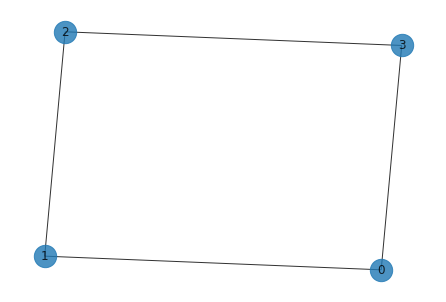

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [4]:
class MaxCutSolver():
    def __init__(self, graph, num_qubits, backend, p = 1):
        self.graph = graph
        self.numqubits = num_qubits
        self.circuit = QuantumCircuit(num_qubits)
        self.backend = backend
        for i in range(0,  self.numqubits):
            self.circuit.h(i)
        gamma = [Parameter("gamma" + str(i)) for i in range(0,p)]
        beta = [Parameter("beta" + str(i)) for i in range(0,p)]
        for j in range(0, p):
            for nodes in list(graph.edges()): 
                self.circuit.rzz(2 * gamma[j], nodes[0], nodes[1])
            for i in range(0,  self.numqubits):
                self.circuit.rx(2 * beta[j], i)

    def get_cost_graph(self, bitstring):
        cost = 0
        for i, j in self.graph.edges():
            if bitstring[i] != bitstring[j]:
                cost -= 1
        return cost

    def output_circuit(self, params):
        backend = Aer.get_backend(self.backend)
        backend.shots = 1000
        qc_res = self.circuit.copy()
        qc_res = qc_res.bind_parameters(params)
        if (self.backend == 'statevector_simulator'):
            result = execute(qc_res, backend).result()
            #statevector = result.get_statevector(qc_res)
            statevector = result.get_counts()
            return statevector
        else:
            qc_res.measure_all()
            counts = backend.run(qc_res).result().get_counts()
            return counts

    def get_expectation(self, params):
        backend = Aer.get_backend(self.backend)
        qc = self.circuit.copy()
        qc = qc.bind_parameters(params)
        qc.measure_all()
        counts = backend.run(qc, nshots=1000).result().get_counts()
        avg = 0
        sum_count = 0
        for bitstring, count in counts.items():
            obj = self.get_cost_graph(bitstring)
            avg += obj * count
            sum_count += count
        return avg/sum_count

    def optimize_classic(self, init_point):
        expectation = self.get_expectation
        res = minimize(expectation, init_point, method='COBYLA')
        return res

    def optimize_swarm(self, interval, dimentions):
        expectation = self.get_expectation
        pso =  PSO(num_particles=20, num_params=dimentions, interval=interval, function=expectation)
        return pso.run(w=0.4,c1=0.1,c2=0.1, num_iterations=100)

    def optimize_bats(self, interval, dimentions):
        expectation = self.get_expectation
        ba = BA(number_of_bats=5, num_dimentions=dimentions, interval=interval, number_of_iterations=50, alfa= 0.1, gamma=0.1)
        return ba.run(expectation)

    def optimize_ants(self, interval, dimentions):
        expectation = self.get_expectation
        aco = ACO(num_params=dimentions,discrete_points=100,interval=interval,
        number_ants=20,q=0.01, evaporation_rate=0.9, num_iterations = 100)
        return aco.run(expectation)
        

# Statevector simulator tests

In [28]:
myanzats = MaxCutSolver(graph=G, num_qubits=4, backend='statevector_simulator')

### Using gradient descent

In [30]:
myanzats.optimize_classic([1.0, 1.0])

     fun: -4.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 21
  status: 1
 success: True
       x: array([2., 1.])

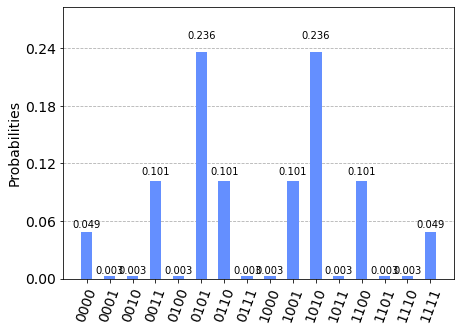

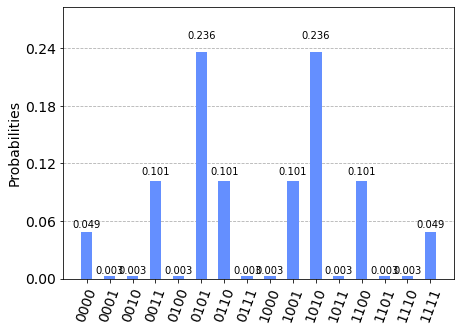

In [31]:
plot_histogram(myanzats.output_circuit([2., 1.]))

### Using swarm particle optimization

In [33]:
myanzats.optimize_swarm([-5,5],dimentions=2)

array([-1.55379202, -1.21940666])

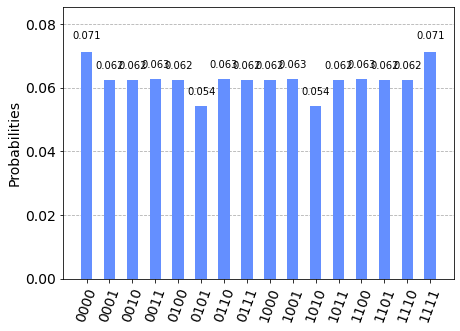

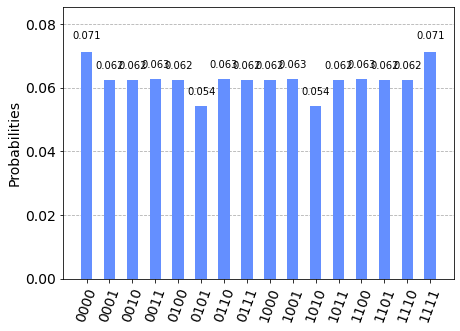

In [34]:
plot_histogram(myanzats.output_circuit([-1.55379202, -1.21940666]))

### Using bat optimization

In [35]:
result = myanzats.optimize_bats([-5,5],dimentions=2)

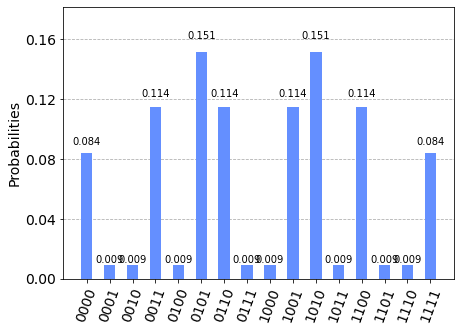

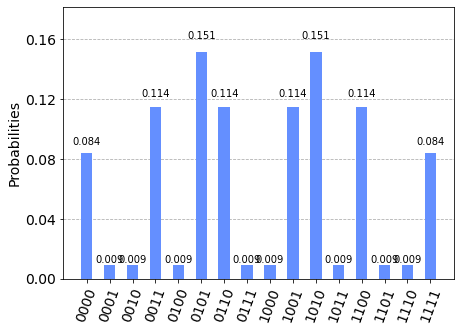

In [36]:
plot_histogram(myanzats.output_circuit(result))

### Using ant colony optimization

In [37]:
result = myanzats.optimize_ants([-5,5],dimentions=2)

solution found


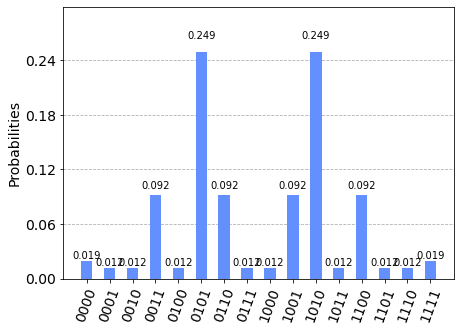

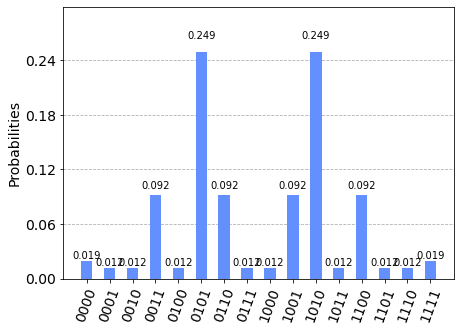

In [38]:
plot_histogram(myanzats.output_circuit(result))

# Qasm simulator tests

In [39]:
myanzats = MaxCutSolver(graph=G, num_qubits=4, backend='qasm_simulator', p=3)

### Using gradient optimization

In [11]:
myanzats.optimize_classic([1.0, 1.0,1.0,1.0,1.0,1.0])

     fun: -3.7421875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 61
  status: 1
 success: True
       x: array([1.15636284, 1.96511396, 2.0819645 , 1.78995338, 0.95706456,
       1.17851319])

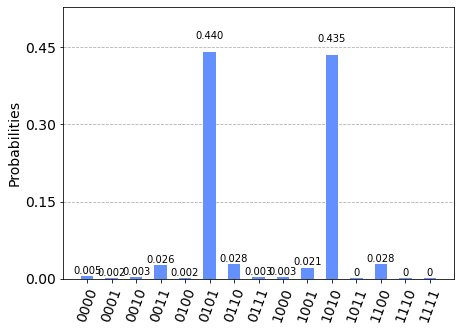

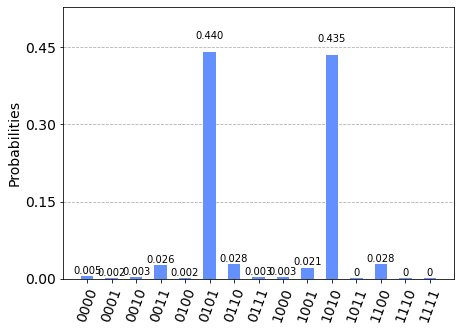

In [13]:
plot_histogram(myanzats.output_circuit([1.15636284, 1.96511396, 2.0819645 , 1.78995338, 0.95706456, 1.17851319]))

### Using particle swarm optimization

In [19]:
myanzats.optimize_swarm([-5,5],dimentions=6)

array([ 0.54244945,  2.85672701, -2.17670318,  0.81136238,  1.83900926,
        2.44190434])

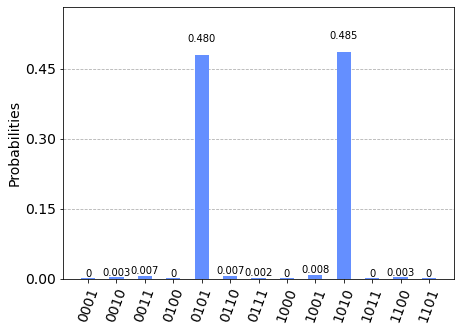

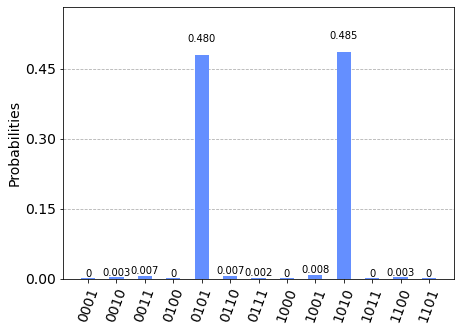

In [20]:
plot_histogram(myanzats.output_circuit([ 0.54244945,  2.85672701, -2.17670318,  0.81136238,  1.83900926,
        2.44190434]))

### Using bat optimization

In [24]:
result = myanzats.optimize_bats([-5,5],dimentions=6)

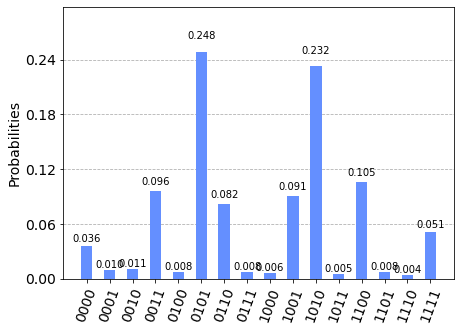

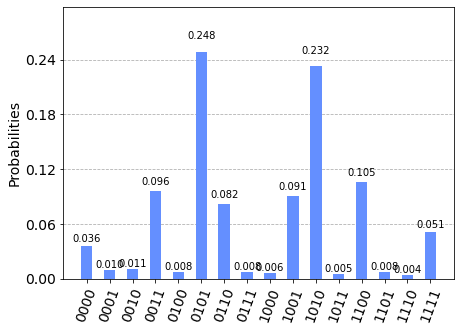

In [25]:
plot_histogram(myanzats.output_circuit(result))

### Using ant colony optimization

In [40]:
result = myanzats.optimize_ants([-5,5],dimentions=6)

solution found


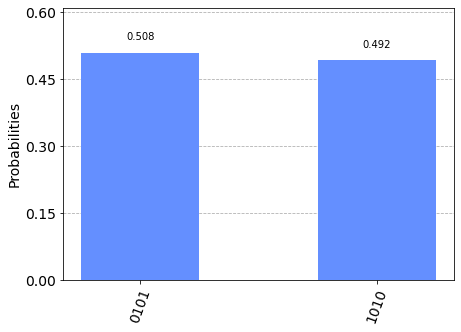

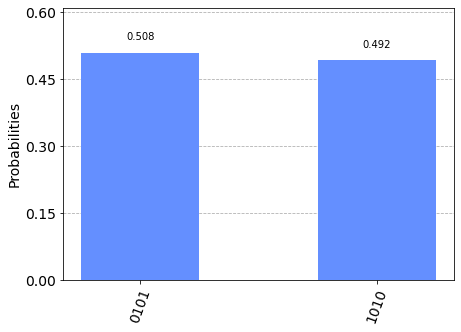

In [41]:
plot_histogram(myanzats.output_circuit(result))

# Comparison between the optimizers

## Statevector simulator

### Approximation ratio vs p-value

In [11]:
gradient_values = list()
swarm_values = list()
bats_values = list()
ants_values = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=4, backend='statevector_simulator', p=i)
    gradient_dict = myanzats.output_circuit(myanzats.optimize_classic([1 for _ in range(0,2*i)]).x)
    swarm_dict = myanzats.output_circuit(myanzats.optimize_swarm([-5,5],dimentions=2*i))
    bats_dict = myanzats.output_circuit(myanzats.optimize_bats([-5,5],dimentions=2*i))
    ants_dict = myanzats.output_circuit(myanzats.optimize_ants([-5,5],dimentions=2*i))
    bats_values.append(bats_dict['0101']/max(bats_dict.values()))
    swarm_values.append(swarm_dict['0101']/max(swarm_dict.values()))
    gradient_values.append(gradient_dict['0101']/max(gradient_dict.values()))
    ants_values.append(ants_dict['0101']/max(ants_dict.values()))

solution found
solution found
solution found
solution found
solution found
solution found
solution found


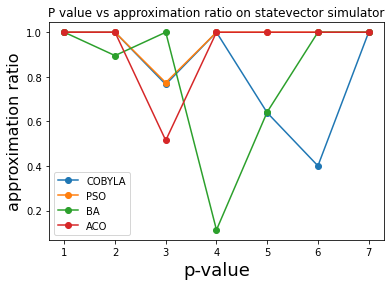

In [12]:
plt.plot(list(range(1,p_range)), gradient_values, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.legend(["COBYLA", "PSO", "BA", "ACO"])
plt.title("P value vs approximation ratio on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('approximation ratio', fontsize=16)
plt.show()

### Ground state probability vs p-value

In [13]:
gradient_values = list()
swarm_values = list()
bats_values = list()
ants_values = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=4, backend='statevector_simulator', p=i)
    gradient_dict = myanzats.output_circuit(myanzats.optimize_classic([1 for _ in range(0,2*i)]).x)
    swarm_dict = myanzats.output_circuit(myanzats.optimize_swarm([-5,5],dimentions=2*i))
    bats_dict = myanzats.output_circuit(myanzats.optimize_bats([-5,5],dimentions=2*i))
    ants_dict = myanzats.output_circuit(myanzats.optimize_ants([-5,5],dimentions=2*i))
    bats_values.append(bats_dict['0101'])
    swarm_values.append(swarm_dict['0101'])
    gradient_values.append(gradient_dict['0101'])
    ants_values.append(ants_dict['0101'])

solution found
solution found
solution found
solution found
solution found
solution found
solution found


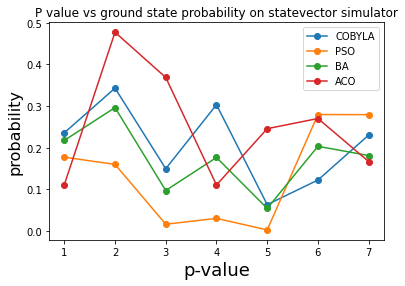

In [14]:
plt.plot(list(range(1,p_range)), gradient_values, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.legend(["COBYLA", "PSO", "BA", "ACO"])
plt.title("P value vs ground state probability on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('probability', fontsize=16)
plt.show()

## Qasm simulator

### Approximation ratio vs p-value

In [9]:
gradient_values = list()
swarm_values = list()
bats_values = list()
ants_values = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=4, backend='qasm_simulator', p=i)
    opt_gradient = myanzats.optimize_classic([1 for _ in range(0,2*i)]).x
    opt_bats = myanzats.optimize_bats([-5,5],dimentions=2*i)
    opt_ants = myanzats.optimize_ants([-5,5],dimentions=2*i)
    opt_swarm = myanzats.optimize_swarm([-5,5],dimentions=2*i)
    mean_gradient = 0
    mean_ants = 0
    mean_bats = 0
    mean_swarm = 0
    for i in range(0,5):
        gradient_dict = myanzats.output_circuit(opt_gradient)
        swarm_dict = myanzats.output_circuit(opt_swarm)
        bats_dict = myanzats.output_circuit(opt_bats)
        ants_dict = myanzats.output_circuit(opt_ants)
        mean_bats += bats_dict['0101']/max(bats_dict.values())
        mean_swarm +=swarm_dict['0101']/max(swarm_dict.values())
        mean_gradient +=gradient_dict['0101']/max(gradient_dict.values())
        mean_ants +=ants_dict['0101']/max(ants_dict.values())
    bats_values.append(mean_bats/5)
    swarm_values.append(mean_swarm/5)
    gradient_values.append(mean_gradient/5)
    ants_values.append(mean_ants/5)

solution found
solution found
solution found
solution found
solution found
solution found
solution found


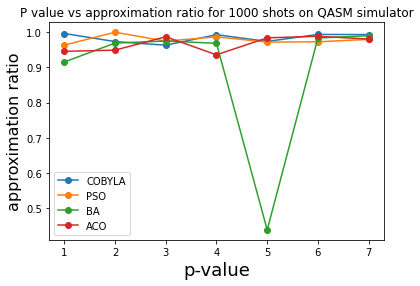

In [10]:
plt.plot(list(range(1,p_range)), gradient_values, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.legend(["COBYLA", "PSO", "BA", "ACO"])
plt.title("P value vs approximation ratio for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('approximation ratio', fontsize=16)
plt.show()

### Ground state probability vs p-value

In [7]:
gradient_values = list()
swarm_values = list()
bats_values = list()
ants_values = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=4, backend='qasm_simulator', p=i)
    opt_gradient = myanzats.optimize_classic([1 for _ in range(0,2*i)]).x
    opt_bats = myanzats.optimize_bats([-5,5],dimentions=2*i)
    opt_ants = myanzats.optimize_ants([-5,5],dimentions=2*i)
    opt_swarm = myanzats.optimize_swarm([-5,5],dimentions=2*i)
    mean_gradient = 0
    mean_ants = 0
    mean_bats = 0
    mean_swarm = 0
    for i in range(0,5):
        mean_gradient += myanzats.output_circuit(opt_gradient)['0101']/1000
        mean_swarm += myanzats.output_circuit(opt_swarm)['0101']/1000
        mean_bats += myanzats.output_circuit(opt_bats)['0101']/1000
        mean_ants += myanzats.output_circuit(opt_ants)['0101']/1000
    bats_values.append(mean_bats/5)
    swarm_values.append(mean_swarm/5)
    gradient_values.append(mean_gradient/5)
    ants_values.append(mean_ants/5)

solution found
solution found
solution found
solution found
solution found
solution found
solution found


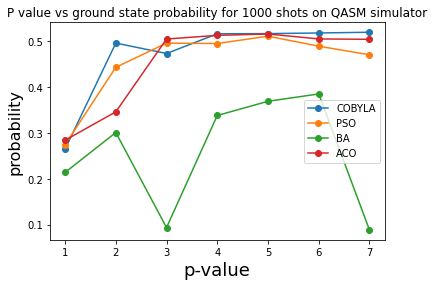

In [8]:
plt.plot(list(range(1,p_range)), gradient_values, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.legend(["COBYLA", "PSO", "BA", "ACO"])
plt.title("P value vs ground state probability for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('probability', fontsize=16)
plt.show()